# 

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import numpy as np

In [3]:
def prepareData(csv, historySize):
    x = []
    y = []
    power = csv.pop('power_normed')
    features = csv
    for i in range(historySize, len(features) - historySize):
        x.append(features[i - historySize : i])
        y.append(sum(power[i : i + 4]))
    return np.array(x), np.array(y)

In [4]:
import pandas as pd
if IN_COLAB:
    file = google.colab.files.upload('Загрузите файл данных с солнечной электростанции')
    data = pd.read_csv(file)
else:
    data = pd.read_csv('~/Study/SolarPower/AutoLSTM/GermanSolarFarm/data/pv_01.csv', delimiter=';')
data = data.drop('Unnamed: 51', axis=1)

In [5]:
from sklearn.model_selection import train_test_split
historyInterval = 2 # 6 hours
x, y = prepareData(data.copy(), historyInterval)
test_idx = int(0.9 * x.shape[0])

x_test = x[test_idx:]
y_test = y[test_idx:]

x_train, x_val, y_train, y_val = train_test_split(x[:test_idx], y[:test_idx], test_size=0.1, shuffle=False)
x_train, y_train

(array([[[1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
          1.72559333e-01, 7.33784730e-01, 9.41977894e-01],
         [2.00000000e+00, 1.42857143e-01, 9.57823644e-01, ...,
          2.04424006e-01, 6.41216667e-01, 9.79643368e-01]],
 
        [[2.00000000e+00, 1.42857143e-01, 9.57823644e-01, ...,
          2.04424006e-01, 6.41216667e-01, 9.79643368e-01],
         [3.00000000e+00, 2.85714286e-01, 8.38278027e-01, ...,
          1.14573407e-01, 8.75927595e-01, 8.29663377e-01]],
 
        [[3.00000000e+00, 2.85714286e-01, 8.38278027e-01, ...,
          1.14573407e-01, 8.75927595e-01, 8.29663377e-01],
         [4.00000000e+00, 4.28571429e-01, 6.61157201e-01, ...,
          7.66661478e-02, 9.43092873e-01, 7.31663898e-01]],
 
        ...,
 
        [[5.02900000e+03, 5.71428571e-01, 4.55788372e-01, ...,
          1.49470609e-01, 7.95221749e-01, 9.03539046e-01],
         [5.03000000e+03, 7.14285714e-01, 2.56175975e-01, ...,
          2.46301594e-01, 5.11603004e-01, 9.99865379e-01]],

In [6]:
import tensorflow as tf
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.LSTM(128, activation='tanh', input_shape=(historyInterval, 50), return_sequences=True))
model.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model.add(layers.LSTM(32, activation='tanh', return_sequences=True))
model.add(layers.LSTM(16, activation='relu'))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()

2023-11-10 01:36:30.472414: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 01:36:30.473947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 01:36:30.495528: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 01:36:30.495559: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 01:36:30.495578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            91648     
                                                                 
 lstm_1 (LSTM)               (None, 2, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 2, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 156625 (611.82 KB)
Trainable params: 156625 (611.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


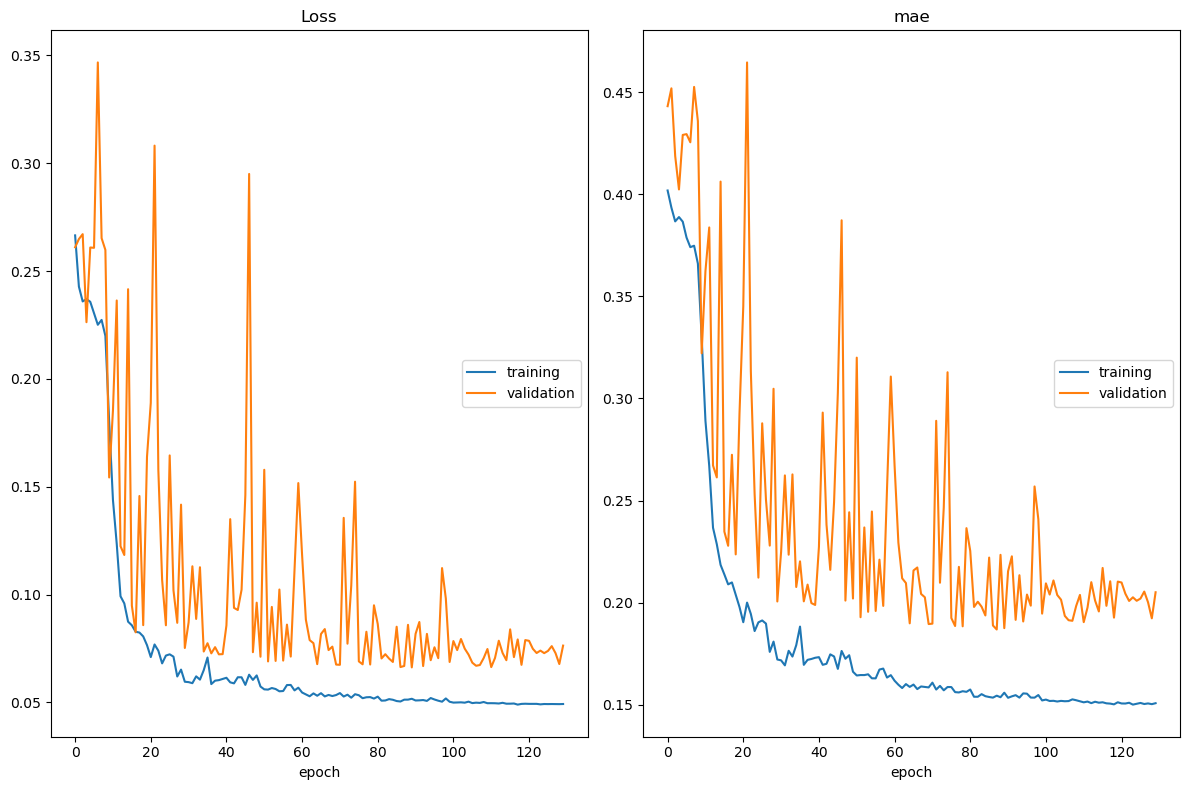

Loss
	training         	 (min:    0.049, max:    0.267, cur:    0.049)
	validation       	 (min:    0.066, max:    0.347, cur:    0.076)
mae
	training         	 (min:    0.150, max:    0.402, cur:    0.151)
	validation       	 (min:    0.187, max:    0.465, cur:    0.205)
158/158 [==============================] - 2s 12ms/step - loss: 0.0492 - mae: 0.1508 - val_loss: 0.0763 - val_mae: 0.2051 - lr: 7.8125e-06
Epoch 131/500
 59/158 [==========>...................] - ETA: 0s - loss: 0.0539 - mae: 0.1578

KeyboardInterrupt: 

In [7]:
from livelossplot import PlotLossesKeras
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8)
model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), callbacks=[PlotLossesKeras(), reduce_lr])

In [8]:
results = model.evaluate(x_test, y_test, batch_size=128)

5/5 [==============================] - 0s 4ms/step - loss: 0.0268 - mae: 0.1159


In [9]:
import matplotlib.pyplot as plt

# Get the training history
history = model.history.history

# Plot the training and validation loss over time
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy over time
plt.plot(history['mae'])
plt.plot(history['val_mae'])
plt.title('Model mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

KeyError: 'loss'